In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

/Users/hhussain0901/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [3]:
def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
def build_generator():
    noise = layers.Input(shape=(100,))
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(10, 100)(label)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise, label_embedding])
    x = layers.Dense(256, activation='relu')(model_input)
    x = layers.Dense(784, activation='sigmoid')(x)
    x = layers.Reshape((28, 28, 1))(x)
    return tf.keras.models.Model([noise, label], x)

In [5]:
def build_discriminator():
    image_input = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(image_input)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    
    validity = layers.Dense(1, activation="sigmoid", name="validity_output")(x)
    label = layers.Dense(10, activation="softmax", name="label_output")(x)
    
    discriminator = tf.keras.models.Model(image_input, [validity, label])
    discriminator.compile(loss=["binary_crossentropy", "sparse_categorical_crossentropy"], optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))
    return discriminator

In [7]:
def train_acgan(generator, discriminator, epochs=10000, batch_size=64):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, 100))
        labels = np.random.randint(0, 10, (batch_size, 1))
        generated_images = generator.predict([noise, labels])
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        real_labels = y_train[np.random.randint(0, y_train.shape[0], batch_size)]
        
        x_combined = np.concatenate([real_images, generated_images])
        validity_combined = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        label_combined = np.concatenate([real_labels, labels.squeeze()])
        
        # Ensure the correct output names are used
        discriminator.train_on_batch(x_combined, {'validity_output': validity_combined, 'label_output': label_combined})

generator = build_generator()
discriminator = build_discriminator()
train_acgan(generator, discriminator)


2/2 [==============================] - 0s 3ms/step


In [8]:
def generate_images(generator, num_samples=10000):
    noise = np.random.normal(0, 1, (num_samples, 100))
    labels = np.random.randint(0, 10, (num_samples, 1))
    generated_images = generator.predict([noise, labels])
    return np.concatenate((x_train, generated_images)), np.concatenate((y_train, labels.squeeze()))

In [9]:
# Train CNN on original data
cnn = create_cnn()
history_orig = cnn.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 22s 11ms/step - loss: 0.2159 - accuracy: 0.9337 - val_loss: 0.0484 - val_accuracy: 0.9858
Epoch 2/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0786 - accuracy: 0.9768 - val_loss: 0.0430 - val_accuracy: 0.9869
Epoch 3/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0581 - accuracy: 0.9826 - val_loss: 0.0259 - val_accuracy: 0.9914
Epoch 4/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0474 - accuracy: 0.9858 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0376 - accuracy: 0.9889 - val_loss: 0.0272 - val_accuracy: 0.9911


In [10]:
# Train CNN on augmented data
x_train_aug, y_train_aug = generate_images(generator)
cnn_aug = create_cnn()
history_aug = cnn_aug.fit(x_train_aug, y_train_aug, epochs=5, validation_data=(x_test, y_test))

313/313 [==============================] - 0s 923us/step
Epoch 1/5
2188/2188 [==============================] - 23s 10ms/step - loss: 0.5016 - accuracy: 0.8186 - val_loss: 0.0446 - val_accuracy: 0.9859
Epoch 2/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3951 - accuracy: 0.8514 - val_loss: 0.0354 - val_accuracy: 0.9880
Epoch 3/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3780 - accuracy: 0.8566 - val_loss: 0.0267 - val_accuracy: 0.9905
Epoch 4/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3707 - accuracy: 0.8587 - val_loss: 0.0295 - val_accuracy: 0.9901
Epoch 5/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3617 - accuracy: 0.8616 - val_loss: 0.0236 - val_accuracy: 0.9920


In [14]:
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0, final_sparsity=0.5, 
        begin_step=0, end_step=np.ceil(len(x_train) / 32).astype(np.int32) * 5)
}

# Apply pruning to the model
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(cnn, **pruning_params)

# Unfreeze some layers (for fine-tuning) if necessary
for layer in pruned_model.layers[-4:]:  # Example: Unfreeze the last 4 layers
    layer.trainable = True

# Recompile the model after unfreezing layers
pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the pruning callback
pruning_callback = UpdatePruningStep()

# Fine-tune the model
history_pruned_aug = pruned_model.fit(x_train_aug, y_train_aug, epochs=5, validation_data=(x_test, y_test), callbacks=[pruning_callback])

Epoch 1/5
2188/2188 [==============================] - 27s 11ms/step - loss: 0.3579 - accuracy: 0.8628 - val_loss: 0.0247 - val_accuracy: 0.9915
Epoch 2/5
2188/2188 [==============================] - 23s 10ms/step - loss: 0.3539 - accuracy: 0.8637 - val_loss: 0.0243 - val_accuracy: 0.9917
Epoch 3/5
2188/2188 [==============================] - 23s 10ms/step - loss: 0.3506 - accuracy: 0.8652 - val_loss: 0.0260 - val_accuracy: 0.9921
Epoch 4/5
2188/2188 [==============================] - 22s 10ms/step - loss: 0.3457 - accuracy: 0.8659 - val_loss: 0.0233 - val_accuracy: 0.9925
Epoch 5/5
2188/2188 [==============================] - 23s 10ms/step - loss: 0.3430 - accuracy: 0.8684 - val_loss: 0.0291 - val_accuracy: 0.9930


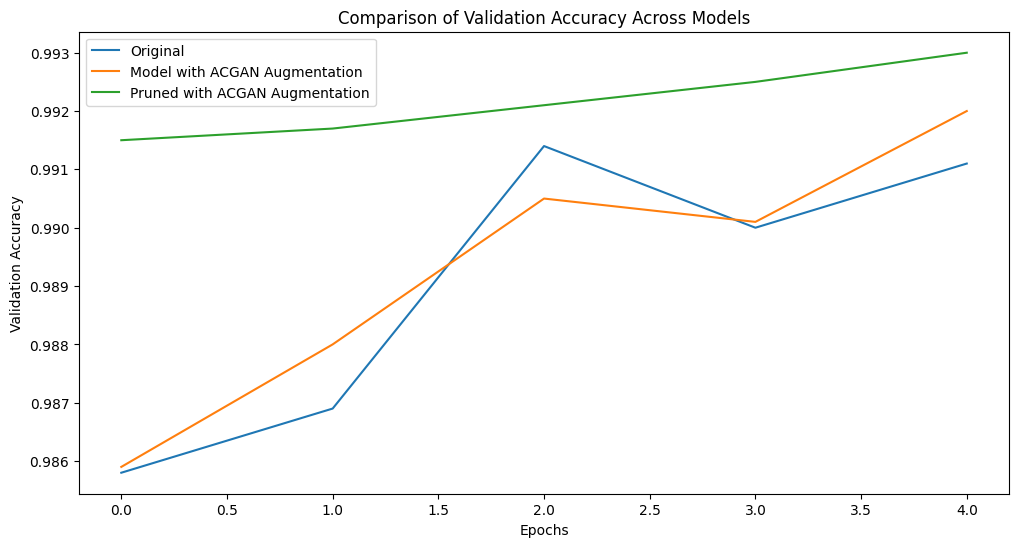

In [15]:
plt.figure(figsize=(12, 6))

# Plot validation accuracy for each model
plt.plot(history_orig.history['val_accuracy'], label='Original')
plt.plot(history_aug.history['val_accuracy'], label='Model with ACGAN Augmentation')
plt.plot(history_pruned_aug.history['val_accuracy'], label='Pruned with ACGAN Augmentation')

# Labeling the axes and adding a title
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracy Across Models')

# Adding a legend to differentiate the lines
plt.legend()

# Display the plot
plt.show()